########################################################################################
# Workshop: Coding for PDEs with Neural Networks
# Date: 2025-24-01
# Author: Danilo Aballay, Vicente Iligaray, Ignacio Tapia y Manuel Sánchez
########################################################################################

In [1]:
import jax.numpy as np
from jax import random, grad, jit, vmap
import jax
import jax.nn as nn
from jax.scipy.optimize import minimize
from jax import lax
import numpy as onp
from jax.experimental.ode import odeint
from jax.example_libraries import optimizers
from jax import block_until_ready
from functools import partial

from Laplace_JAXDense import solve_and_loss, solve, softmax_nodes

key = random.PRNGKey(0)


# Estructura red neuronal

def init_params(layers, key):
    Ws = []
    bs = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2 / (layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1])) * std_glorot)
        bs.append(np.zeros(layers[i + 1]))
    return [Ws, bs]

# @jit
def forward_pass(A_t, params):
    Ws, bs = params
    H = A_t
    for i in range(len(Ws) - 1):
        H = np.matmul(H, Ws[i]) + bs[i]
        H = np.tanh(H)
    alpha = np.matmul(H, Ws[-1]) + bs[-1]
    return alpha

@jit
def loss(params, sigmas):
    thetas = forward_pass(sigmas, params)
    mapped_function = jax.vmap(solve_and_loss, in_axes=(0, 0))
    ritz = mapped_function(thetas[:, None], sigmas)
    return np.sum(ritz)

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, sigmas):
    params = get_params(opt_state)
    grads  = grad(loss)(params, sigmas)
    return opt_update(0, grads, opt_state)

def FEM_sol(params, sigma):
    thetas = forward_pass(sigma, params)
    return solve(thetas, sigma)

def train(loss_fn, opt_state,sigmas, nIter=10000):
    train_loss = []
    for it in range(nIter):
        params = get_params(opt_state)
        grads  = grad(loss_fn)(params, sigmas)
        opt_state = opt_update(0, grads, opt_state)
        # opt_state = step(loss, it, opt_state, A, C, t_span, lb, ub)

        if it % 10 == 0:
            params = get_params(opt_state)
            loss_val = loss_fn(params, sigmas)
            train_loss.append(loss_val)
            print(f"Iteración {it}, pérdida: {loss_val:.4e}")

    return get_params(opt_state), train_loss



In [30]:
neurons = 10
layers  = 3
n_nodes = 16
iter    = 10000
sigmas     = np.linspace(0.1,100,100)
sigmas     = sigmas[:, None]

# Parámetros de la red neuronal
layers = [1, 10, 10, n_nodes]
key    = random.PRNGKey(42)

# Entrenamiento
opt_init, opt_update, get_params = optimizers.adam(1e-3)
params    = init_params(layers, key)
opt_state = opt_init(params)

# Configurar los parámetros
trained_param, trained_error = train(loss, opt_state, sigmas, iter)

Iteración 0, pérdida: -4.6502e+01
Iteración 10, pérdida: -4.8066e+01
Iteración 20, pérdida: -4.8893e+01
Iteración 30, pérdida: -4.9274e+01
Iteración 40, pérdida: -4.9515e+01
Iteración 50, pérdida: -4.9683e+01
Iteración 60, pérdida: -4.9803e+01
Iteración 70, pérdida: -4.9890e+01
Iteración 80, pérdida: -4.9954e+01
Iteración 90, pérdida: -5.0004e+01
Iteración 100, pérdida: -5.0045e+01
Iteración 110, pérdida: -5.0077e+01
Iteración 120, pérdida: -5.0102e+01
Iteración 130, pérdida: -5.0123e+01
Iteración 140, pérdida: -5.0140e+01
Iteración 150, pérdida: -5.0155e+01
Iteración 160, pérdida: -5.0168e+01
Iteración 170, pérdida: -5.0180e+01
Iteración 180, pérdida: -5.0192e+01
Iteración 190, pérdida: -5.0202e+01
Iteración 200, pérdida: -5.0212e+01
Iteración 210, pérdida: -5.0222e+01
Iteración 220, pérdida: -5.0230e+01
Iteración 230, pérdida: -5.0239e+01
Iteración 240, pérdida: -5.0247e+01
Iteración 250, pérdida: -5.0255e+01
Iteración 260, pérdida: -5.0262e+01
Iteración 270, pérdida: -5.0270e+01
Ite

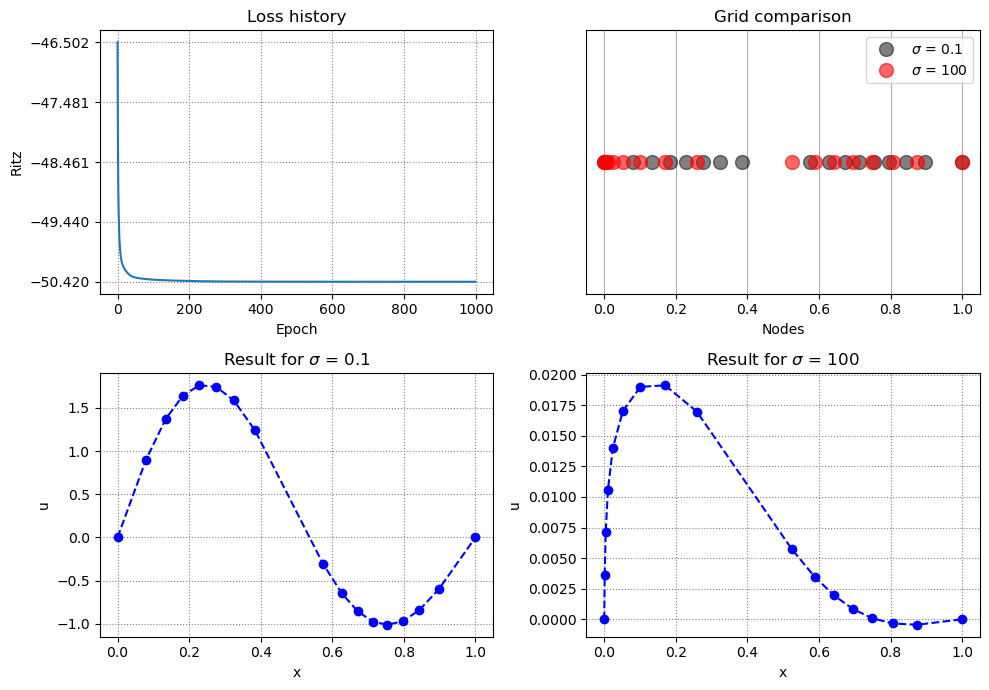

In [33]:
import matplotlib.pyplot as plt

node_coords_first, u_first = FEM_sol(trained_param, np.array([sigmas[0]]))
node_coords_last, u_last = FEM_sol(trained_param, np.array([sigmas[-1]]))

# Plot loss history
plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.plot(trained_error)
plt.xlabel('Epoch')
plt.ylabel('Ritz')
min_loss = min(trained_error)
max_loss = max(trained_error)
ticks = np.linspace(min_loss, max_loss, num=5)  # Ajusta el número de ticks según sea necesario
plt.yticks(ticks)
plt.grid(which='both', axis='both', linestyle=':', color='gray')
plt.tight_layout()
plt.title('Loss history')
# plt.savefig('../Figures/Loss_history' + str(nn) + '_iter' + str(iterations) + '.png')




# Graficar la grilla con espaciamiento variable
plt.subplot(2,2,2)
plt.plot(node_coords_first, np.zeros(len(node_coords_first)),'o', color='k', alpha=0.5, markersize=10)
plt.plot(node_coords_last, np.zeros(len(node_coords_last)),'o', color='r', alpha=0.6, markersize=10)
plt.xlabel('Nodes')
plt.title('Grid comparison')
plt.legend(['$\sigma$ = 0.1', '$\sigma$ = 100'])
plt.yticks([])
plt.grid(True)
# plt.savefig('../Figures/grid_comparison' + str(nn) + '_iter' + str(iterations) + '.png')

# # Plot the approximate solution obtained from the trained model
plt.subplot(2,2,3)
plt.plot(node_coords_first, u_first,'o--', color='b')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Result for $\sigma$ = 0.1')
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

# Guardar la figura en el directorio Figures
# plt.savefig('../Figures/r_adaptivity_sparse_nodes' + str(nn) + '_iter' + str(iterations) + '.png')

plt.subplot(2,2,4)
plt.plot(node_coords_last, u_last,'o--', color='b')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Result for $\sigma$ = 100')
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

# Plot Grid Mesh

# Crear la figura

plt.show()

